In [1]:
import pandas as pd
import numpy as np

import json

In [2]:
bids = pd.read_csv('../data/bid_requests.csv')
users = pd.read_csv('../data/user_attributes.csv')

In [31]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   600000 non-null  object
 1   user_id     600000 non-null  object
 2   bid         600000 non-null  int64 
 3   win         600000 non-null  int64 
 4   conversion  600000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 22.9+ MB


In [3]:
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [4]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [5]:
txt = users.attributes[1]

In [6]:
dic = json.loads(txt)

In [7]:
atts = pd.DataFrame(columns=['age', 'gender', 'location', 'test'])

In the interest of time, I've commented out the next two cells:
* the first cell creates a dataframe from the attributes textblob in the users dataframe. That process is extremely slow
* in the following cell, I save that attributes dataframe as a csv, so we can just read it in whenever we re-run the notebook

Of course, if you have time on your hands, or a GPU, I invite you to uncomment out the next cell and run it at your discretion.

In [8]:
# for i in range(len(users.attributes)):
#     dic = json.loads(users.attributes[i])
    
#     for k in dic:
#         dic[k] = [dic[k]]
        
#     df = pd.DataFrame.from_dict(dic)
    
#     atts = atts.append(df, ignore_index=True)
    
        

In [9]:
# atts.to_csv('../data/atts.csv', index=False)

In [10]:
atts = pd.read_csv('../data/atts.csv')

In [11]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   age       100000 non-null  int64 
 1   gender    100000 non-null  object
 2   location  100000 non-null  object
 3   test      100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [12]:
cols = atts.columns.to_list()
cols.insert(0, 'user_id')
cols

['user_id', 'age', 'gender', 'location', 'test']

In [13]:
atts['user_id'] = users['user_id']

In [14]:
atts = atts[cols]

In [15]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   100000 non-null  object
 1   age       100000 non-null  int64 
 2   gender    100000 non-null  object
 3   location  100000 non-null  object
 4   test      100000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [16]:
atts.user_id[0] == users.user_id[0]

True

In [17]:
atts.head()

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


In [18]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [19]:
control = atts[atts['test']==0]
test = atts[atts['test']==1]

In [20]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43916 entries, 3 to 99997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   43916 non-null  object
 1   age       43916 non-null  int64 
 2   gender    43916 non-null  object
 3   location  43916 non-null  object
 4   test      43916 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56084 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   56084 non-null  object
 1   age       56084 non-null  int64 
 2   gender    56084 non-null  object
 3   location  56084 non-null  object
 4   test      56084 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.6+ MB


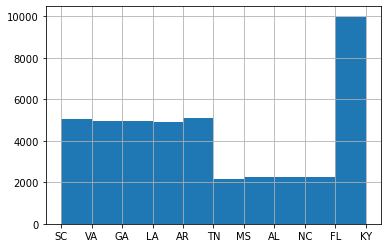

In [23]:
control.location.hist();

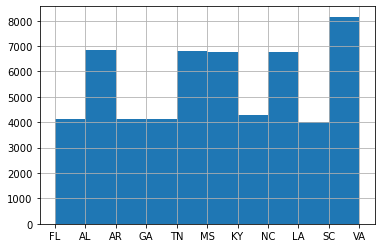

In [24]:
test.location.hist();

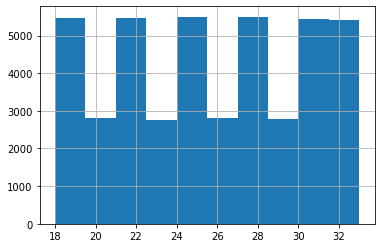

In [27]:
control.age.hist();

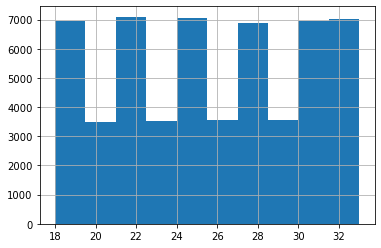

In [26]:
test.age.hist();

In [29]:
control.gender.value_counts()

M    22101
F    21815
Name: gender, dtype: int64

In [30]:
test.gender.value_counts()

F    28108
M    27976
Name: gender, dtype: int64

In [38]:
control_bids = bids[bids['user_id'].isin(control.user_id.values)]

In [36]:
test_bids = bids[bids['user_id'].isin(test.user_id.values)]

In [40]:
control_bids.describe()

,bid,win,conversion
count,262107.000000,262107.000000,262107.000000
mean,0.499777,0.250142,0.010389
std,0.500001,0.433096,0.101395
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [41]:
test_bids.describe()

,bid,win,conversion
count,337893.000000,337893.000000,337893.000000
mean,0.499703,0.250360,0.010039
std,0.500001,0.433221,0.099689
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000
